In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

import os
from env import username, password, host
import env

import acquire as a
import prepare as p

import warnings
warnings.filterwarnings("ignore")

----

### <u> Zillow Regression Project - Estimating Housing Value<u>
     Reported by Jerry Nolf  -  March 30, 2022

----

### Project Description: 

Zillow offers a lot to value to real estate professionals, customers, and the public by offering usable real estate data on its sites. From buying properties to selling them, Zillow offers these resources to help in all facets of the real estate market. 

This project has been requested, per email from the Data Science Team, in order to help improve the current Zillow machine learning model that can properly assess property tax values of single family residences. 

#### Project Goal:

The goal of this project is to identify key drivers of property tax values for single family properties purchased in 2017 and to create an improved machine learning regression model that will improve upon our baseline.

These drivers will help us better understand just how impactful certain key elements of these properties are or are not. In turn, they will help to create a more refined model through this project along with future fine-tuning.

----

### Acquiring the data:

Our data will be pulled from our Zillow database. In our SQL query, we joined the following relational databases together:

    - properties_2017
    - propertylandusetype
    - predictions_2017
   
With these joined, we were able to access the following tables of information for Single Family Residential homes with a transaction date in 2017:

    - Bedroom Count
    - Bathroom Count
    - Calculated Finished Square Footage
    - Lot Square Footage
    - FIPS
    - Tax Value
    
This will allow for the gathering of all relevant data into one database. Once the data is acquired for the first time, it will create a .csv file that can be pulled from the active directory.

An acquire.py file was then created in order to perform the above steps by simply importing acquire and using it's local 'acquire_zillow' function. 

In [2]:
# Acquire our data
df = a.acquire_zillow()
df.shape

Using cached csv


(52441, 7)

After acquiring and specifying the data we want using our SQL query, we see that it results in a DataFrame that contains 52,441 rows and 7 columns.



----

### Preparing the data:

After acquisition, the prepare.py file can be used to clean the data and conduct feature engineering prior to splitting into 'train, validate, test'. The wrangle_zillow function will be called to do the following:

     - Remove outliers that will skew our data
         - Used a quantile based function
         - sqft greater than 500 and less than 3,000
         - bathrooms greater than or equal to 1
     - Drop any null values that will impede the ML process
     - Ensure that used columns are integer values
     - Rename the fips codes to the counties ZACH LOST!!! smh
     - Rename 'fips' to 'county' to better describe the column 
     - Split our data into proper train, validate, and test samples
     - Combine all these actions into a single callable function
     

In [3]:
train, validate, test = p.wrangle_zillow(df)
train.shape, validate.shape, test.shape

((18278, 7), (7834, 7), (6529, 7))

How many rows are we left with after dropping outliers and nulls?

In [4]:
train.shape[0]+validate.shape[0]+test.shape[0]

32641

How many rows were dropped because of outliers and nulls? 

In [5]:
df.shape[0] - (train.shape[0]+validate.shape[0]+test.shape[0])

19800

#### Worth noting:
Dropping the *19,800* outliers and nulls may pose a problem; especially when trying to work with outliers in the future.

In [6]:
train.head(2)

,bedrooms,bathrooms,sqft,tax_value,yr_built,lot_sqft,county
25550,3,2.0,1258,392583,1956,6000,Orange
47111,5,3.0,1929,520296,1964,6002,Los Angeles


After running our split, our data remains in 7 columns but our rows have decreased in size to 56% for the training data set, 24% for the validate dataset, and 20% for our test dataset. This helps us determine that our split was done correctly.

----

### Explore the data:

To start our exploration, we take a look a a horizontal bar graph that will allow us the visualize the the strength of corrleation between our categories pulled from our database and tax value of properties. This will help us identify key drivers.

Text(0.5, 0, 'Strength of Correlation to Tax Value')

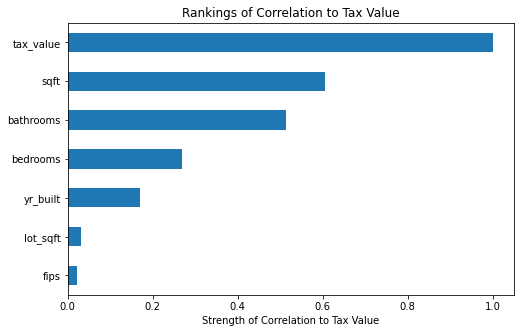

In [7]:
hbar_corr = df.corr()['tax_value'].sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Rankings of Correlation to Tax Value')
plt.xlabel('Strength of Correlation to Tax Value')

After a quick overview, we're faced with a few questions and a need for more evidence related to the drivers we've identified so far:

    - What county has the highest tax values?
    - Does house square footage affect tax value?
    - Does number of bedrooms affect tax value?
    - Does number of bathrooms affect tax value?
       
Let's continue and take a look...

#### What county has the highest tax values?

Let's use a boxplot to see if there are any obvious differences between counties in terms of tax values.

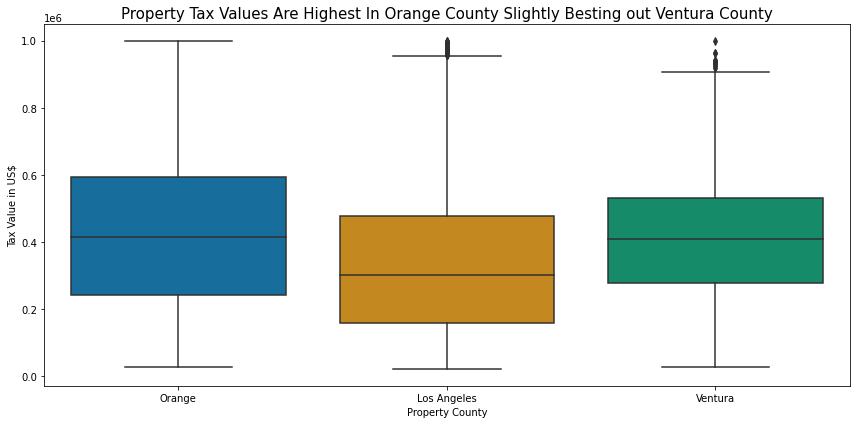

In [8]:
plt.figure(figsize=(12,6))

sns.boxplot(x='county', y='tax_value', data=train , palette='colorblind')
plt.title('Property Tax Values Are Highest In Orange County Slightly Besting out Ventura County', fontsize=15)
plt.ylabel('Tax Value in US$')
plt.xlabel('Property County')
plt.tight_layout()

#### In conclusion:

Based on our visualization, we see that Orange county homes, on average, have the highest tax values by slightly higher than Ventura county and by a more higher than Los Angeles county.

#### Does a house's square footage affect tax value?

Text(6.799999999999997, 0.5, 'Tax Value in US$')

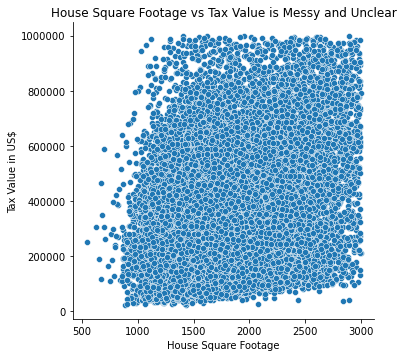

In [9]:

ax1 = sns.relplot(x ='sqft', y ='tax_value', data = train,
            palette = 'colorblind',kind = 'scatter')
plt.title('House Square Footage vs Tax Value is Messy and Unclear')
plt.ticklabel_format(style = 'plain')
plt.xlabel('House Square Footage')
plt.ylabel('Tax Value in US$')


With an unclear visual, let's establish a hypothesis and try to find some clarity through statistics:

#### Hypothesis:
 - H0: There is no linear relationship between a houses's square footage and tax value of a property.
 
 - Ha: There is a linear relationship between a houses's square footage and tax value of a property.

Let's take a look at whether a Pearson's R allows to accept our null hypothesis... 

In [10]:
# Set our alpha
alpha = .05

# Set what info we want and run Pearson's R on our two train sets
r, p = pearsonr(train.sqft, train.tax_value)


# Set our parameters to print our answer
if p > alpha:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

r-value = 0.35115
p-value = 0.0
The null hypothesis is rejected! 


#### In conclusion:

We can use our statistical analysis and visualizations to determine that there is a linear relationship between a houses's square footage and tax value.

#### Does number of bedrooms affect tax value?

Text(0, 0.5, 'Tax Value in US$')

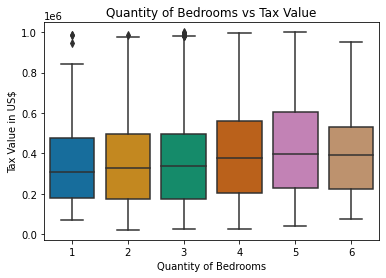

In [35]:
sns.boxplot(x ='bedrooms', y ='tax_value', data = train, palette ='colorblind')
plt.title('Quantity of Bedrooms vs Tax Value')
plt.xlabel('Quantity of Bedrooms')
plt.ylabel('Tax Value in US$')

Number of bedrooms is a driver. Let's take a look at a Pearson's R test after establishing our hypothesis.

#### Hypothesis:
 - H0: There is no linear relationship between number of bedrooms and tax value of a property.
 
 - Ha: There is a linear relationship between number of bedrooms and tax value of a property.

In [12]:
# Set our alpha
alpha = .05

# Set what info we want and run Pearson's R on our two train sets
r, p = pearsonr(train.bedrooms, train.tax_value)

# Set our parameters to print our answer
if p > alpha:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

r-value = 0.0882
p-value = 0.0
The null hypothesis is rejected! 


#### In conclusion:

We can use our statistical analysis to determine that there is a linear relationship between number of bedrooms and tax value.

#### Does number of bathrooms affect tax value?

Text(0, 0.5, 'Tax Value in US$')

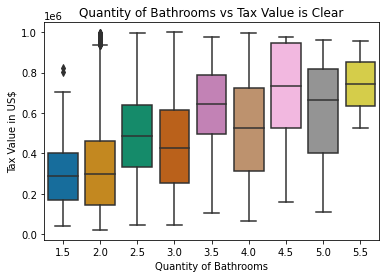

In [37]:
sns.boxplot(x ='bathrooms', y ='tax_value', data = train, palette ='colorblind')
plt.title('Quantity of Bathrooms vs Tax Value is Clear')
plt.xlabel('Quantity of Bathrooms')
plt.ylabel('Tax Value in US$')

Full bathrooms are nice. Half-baths are NICER for tax value. Let us go back to our Pearson's R to look at the categories liinear relationship wit htax value.

#### Hypothesis:
 - H0: There is no linear relationship between number of bathrooms and tax value of a property.
 
 - Ha: There is a linear relationship between number of bathrooms and tax value of a property.

In [14]:
# Set our alpha
alpha = .05

# Set what info we want and run Pearson's R on our two train sets
r, p = pearsonr(train.bathrooms, train.tax_value)

# Set our parameters to print our answer
if p > alpha:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'r-value = {round(r,5)}')
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

r-value = 0.27716
p-value = 0.0
The null hypothesis is rejected! 


#### In conclusion:

We can use our statistical analysis to determine that there is a linear relationship between number of bathrooms and tax value.

### Modeling

We start our modeling by establishing our baseline and making a column on the end of our train, validate, and test dataframes.

#### Set x's and y's:

In [15]:
# Define the X and y's while dropping the target 
target = 'tax_value'
    
# Split train into x (dataframe, drop target) & y (series, keep target only)
x_train = train.drop(columns=[target])
y_train = train[target]

# Split validate into x (dataframe, drop target) & y (series, keep target only)
x_validate = validate.drop(columns=[target])
y_validate = validate[target]

# Split test into x (dataframe, drop target) & y (series, keep target only)
x_test = test.drop(columns=[target])
y_test = test[target]

#### Set the baseline:

In [16]:
# Turn y_train and y_validate into dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Calculate tax_value median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# Calcualte RMSE of tax_value_pred_mean
basemedian_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
basemedian_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print('====================================')
print('         RMSE using Median  ')
print('====================================')
print("RMSE using Median\nTrain/In-Sample: ", round(basemedian_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(basemedian_rmse_validate, 2))
print('------------------------------------')

         RMSE using Median  
RMSE using Median
Train/In-Sample:  226057.9 
Validate/Out-of-Sample:  227348.73
------------------------------------


#### Scale the data:

In [17]:
# Define our columns for scaling
scale_cols = ['bedrooms', 'bathrooms', 'sqft', 'lot_sqft']

#Make the scaler
scaler = sklearn.preprocessing.MinMaxScaler()

#Fit the scaler
scaler.fit(x_train[scale_cols])

# Use the scaler and make each scaled set a DataFrame
x_train_scaled = scaler.transform(x_train[scale_cols])
x_train_scaled = pd.DataFrame(x_train_scaled, columns = scale_cols)

x_validate_scaled = scaler.transform(x_validate[scale_cols])
x_validate_scaled = pd.DataFrame(x_validate_scaled, columns = scale_cols)

x_test_scaled = scaler.transform(x_test[scale_cols])
x_test_scaled = pd.DataFrame(x_test_scaled, columns = scale_cols)

# Convert y to DataFrame
y_train = pd.DataFrame(y_train)

y_validate = pd.DataFrame(y_validate)

y_test  = pd.DataFrame(y_test)

#### RFE:

Justify our features used and ensure no major drivers were missed with using Recursive Feature Elimination.

In [18]:
# Make the RFE object
lm = LinearRegression() 
rfe = RFE(lm, n_features_to_select=3)

# Fit the RFE 
rfe.fit(x_train_scaled, y_train.tax_value)

# Use the RFE
rfe_features = x_train_scaled.columns[rfe.support_].tolist()
print(f'RFE features for predicting tax value are: {rfe_features}')

RFE features for predicting tax value are: ['bedrooms', 'bathrooms', 'sqft']


#### Modeling for our data:

We create our features and add in lot square footage in order to better set up our model.

In [19]:
# Define our modeling features:
features = ['bedrooms', 'bathrooms', 'sqft', 'lot_sqft']

#### Linear Regression:

In [20]:
# Create the model
lm = LinearRegression(normalize=True)

# Fit the model 
lm.fit(x_train_scaled[features], y_train['tax_value'])

# Set predictions
y_train['tax_value_pred_lm'] = lm.predict(x_train_scaled[features])

# Evaluate RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# Predict validate 
y_validate['tax_value_pred_lm'] = lm.predict(x_validate_scaled[features])

# Evaluate RMSE on validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2))

RMSE for OLS using LinearRegression
Training/In-Sample:  208294.39 
Validation/Out-of-Sample:  208672.8


#### LassoLars:

In [21]:
# Create the model
lars = LassoLars(alpha=1.0)

# Fit the model  
lars.fit(x_train_scaled[features], y_train.tax_value)

# Predict train
y_train['tax_value_pred_lars'] = lars.predict(x_train_scaled[features])

# Evaluate RMSEon validate
rmse_train2 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(x_validate_scaled[features])

# evaluate: rmse
rmse_validate2 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train2,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate2,2))

RMSE for Lasso + Lars
Training/In-Sample:  208294.64 
Validation/Out-of-Sample:  208676.57


#### TweedieRegressor (GLM):

In [22]:
# Create the model
glm = TweedieRegressor(power=1, alpha=0)

#Fit the model 
glm.fit(x_train_scaled[features], y_train.tax_value)

# Predict train
y_train['tax_value_pred_glm'] = glm.predict(x_train_scaled[features])

# Evaluate: rmse
rmse_train3 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# Predict validate
y_validate['tax_value_pred_glm'] = glm.predict(x_validate_scaled[features])

# Evaluate: rmse
rmse_validate3 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train3,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate3,2))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  208296.0 
Validation/Out-of-Sample:  208749.28


#### Polynomial Features:

In [23]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train_scaled[features])

# Transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate_scaled[features])
# x_test_degree2 = pf.transform(x_test)


In [24]:
# Create the model
lm2 = LinearRegression(normalize=True)

# Fit the model 
lm2.fit(x_train_degree2, y_train.tax_value)

# Set predictions
y_train['tax_value_pred_lm2'] = lm2.predict(x_train_degree2)

# Evaluate RMSE for train
rmse_train4 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# Predict validate 
y_validate['tax_value_pred_lm2'] = lm2.predict(x_validate_degree2)

# Evaluate RMSE for validate
rmse_validate4 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Features using LinearRegression\nTraining/In-Sample: ", round(rmse_train4,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate4,2))

RMSE for Polynomial Features using LinearRegression
Training/In-Sample:  207168.5 
Validation/Out-of-Sample:  208064.58


In [25]:
print('===================================================')
print("RMSE for Baseline using Median\nTrain/In-Sample: ", round(basemedian_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(basemedian_rmse_validate, 2))
print('===================================================')
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2))
print('---------------------------------------------------')
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train2,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate2,2))
print('---------------------------------------------------')
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train3,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate3,2))
print('---------------------------------------------------')
print("RMSE for Polynomial Features using LinearRegression\nTraining/In-Sample: ", round(rmse_train4,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate4,2))
print('===================================================')

RMSE for Baseline using Median
Train/In-Sample:  226057.9 
Validate/Out-of-Sample:  227348.73
RMSE for OLS using LinearRegression
Training/In-Sample:  208294.39 
Validation/Out-of-Sample:  208672.8
---------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  208294.64 
Validation/Out-of-Sample:  208676.57
---------------------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  208296.0 
Validation/Out-of-Sample:  208749.28
---------------------------------------------------
RMSE for Polynomial Features using LinearRegression
Training/In-Sample:  207168.5 
Validation/Out-of-Sample:  208064.58


#### Use Our Best Model (Polynomial Features) On Test:

In [26]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train_scaled[features])

# Transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate_scaled[features])
# x_test_degree2 = pf.transform(x_test)

In [27]:
# Create the model
lm2 = LinearRegression(normalize=True)

# Fit the model 
lm2.fit(x_test_scaled[features], y_test['tax_value'])

# Set predictions
y_test['tax_value_pred_lm'] = lm2.predict(x_test_scaled[features])

# Predict validate 
y_test['tax_value_pred_lm'] = lm2.predict(x_test_scaled[features])

# Evaluate RMSE for validate
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

print ('---------------------------------------------')
print("Baseline RMSE for Validate Sample: ", round(basemedian_rmse_validate, 2))
print("RMSE for Test Sample: ", round(rmse_test,2))
print ('---------------------------------------------')
print("Our model beats the baseline by ", (round(basemedian_rmse_validate-rmse_test,2)))
print ('---------------------------------------------')

---------------------------------------------
Baseline RMSE for Validate Sample:  227348.73
RMSE for Test Sample:  208422.7
---------------------------------------------
Our model beats the baseline by  18926.03
---------------------------------------------


### Conclusion:


The goals of this project were to identify key drivers of tax value for single family residential homes purchased during 2017. These key drivers were found to be the following:

    - House Square Footage
    - Number of Bedrooms
    - Number of Bathrooms
    
Using these drivers, along with lot square footage, we're able to build a model that is expected to perform with an RMSE of $208,423 on unseen data.

#### Recommendation(s):

- Number of bedrooms and bathrooms along with house and lot square footage can be used to help improve the performance of a machine learning regression model.

- While our model does work to improve on our baseline, higher quality data is needed in order to fine-tune our model. Our new model used data that had to drop *19,800* rows in order to had true usable data.

#### Next Steps:

With more time, I would like to:
 - Work on more feature engineering and explore relationship of categories to tax value further.
 
 - Gather more adequate and complete data that will allow for a clearer picture and the possibility for a more refined and detailed model.